0 0 loss: 0.3263561725616455
eval/loss: 0.093782
1 0 loss: 0.1136658564209938
2 0 loss: 0.10048267990350723
Colorbot is ready to generate colors!
Give me a color name (or press enter to exit): red
rgb: (173, 94, 65)
Give me a color name (or press enter to exit): aqua
rgb: (165, 148, 150)
Give me a color name (or press enter to exit): apple
rgb: (194, 129, 132)
Give me a color name (or press enter to exit): deep carmine
rgb: (201, 122, 124)
Give me a color name (or press enter to exit): 


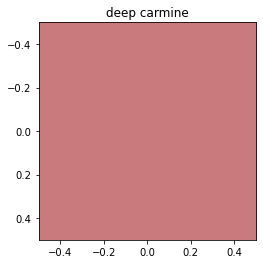

In [3]:
import  os, six, time
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras

from    matplotlib import pyplot as plt

from    utils import load_dataset, parse
from    model import RNNColorbot

tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')







def test(model, eval_data):
    """
    Computes the average loss on eval_data, which should be a Dataset.
    """
    avg_loss = keras.metrics.Mean()

    for (labels, chars, sequence_length) in eval_data:

        predictions = model((chars, sequence_length), training=False)
        avg_loss.update_state(keras.losses.mean_squared_error(labels, predictions))

    print("eval/loss: %.6f" % avg_loss.result().numpy())



def train_one_epoch(model, optimizer, train_data, log_interval, epoch):
    """
    Trains model on train_data using optimizer.
    """

    for step, (labels, chars, sequence_length) in enumerate(train_data):

        with tf.GradientTape() as tape:
            predictions = model((chars, sequence_length), training=True)
            loss = keras.losses.mean_squared_error(labels, predictions)
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


        if step % 100 == 0:
            print(epoch, step, 'loss:', float(loss))


SOURCE_TRAIN_URL = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/archive/extras/colorbot/data/train.csv"
SOURCE_TEST_URL = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/archive/extras/colorbot/data/test.csv"


def main():

    batchsz = 64
    rnn_cell_sizes = [256, 128]
    epochs = 3

    data_dir = os.path.join('.', "data")
    train_data = load_dataset(
        data_dir=data_dir, url=SOURCE_TRAIN_URL, batch_size=batchsz)
    eval_data = load_dataset(
        data_dir=data_dir, url=SOURCE_TEST_URL, batch_size=batchsz)

    model = RNNColorbot(
        rnn_cell_sizes=rnn_cell_sizes,
        label_dimension=3,
        keep_prob=0.5)
    optimizer = keras.optimizers.Adam(0.01)



    for epoch in range(epochs):

        start = time.time()
        train_one_epoch(model, optimizer, train_data, 50, epoch)
        end = time.time()
        # print("train/time for epoch #%d: %.2f" % (epoch, end - start))

        if epoch % 10 == 0:
            test(model, eval_data)

    print("Colorbot is ready to generate colors!")
    while True:
        try:
            color_name = six.moves.input("Give me a color name (or press enter to exit): ")
        except EOFError:
            return

        if not color_name:
            return

        _, chars, length = parse(color_name)

        (chars, length) = (tf.identity(chars), tf.identity(length))
        chars = tf.expand_dims(chars, 0)
        length = tf.expand_dims(length, 0)
        preds = tf.unstack(model((chars, length), training=False)[0])

        # Predictions cannot be negative, as they are generated by a ReLU layer;
        # they may, however, be greater than 1.
        clipped_preds = tuple(min(float(p), 1.0) for p in preds)
        rgb = tuple(int(p * 255) for p in clipped_preds)
        print("rgb:", rgb)
        data = [[clipped_preds]]

        plt.imshow(data)
        plt.title(color_name)
        plt.savefig(color_name+'.png')
main()